Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf
from keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras
from keras.utils import np_utils
from keras.preprocessing import image

Loading Dataset

In [2]:
data = pd.read_csv("venv/Data/fer2013.csv")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Training and testing data

In [3]:
df = data[(data["Usage"] == "Training") | (data["Usage"] == "PublicTest")].reset_index(drop=True)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
dfpt = data[data["Usage"] == "PrivateTest"].reset_index(drop=True)
dfpt.head()

,emotion,pixels,Usage
0,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
1,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
2,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
3,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
4,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest


In [5]:
df["Usage"].value_counts()

Training      28709
PublicTest     3589
Name: Usage, dtype: int64

In [6]:
dfpt["Usage"].value_counts()

PrivateTest    3589
Name: Usage, dtype: int64

In [7]:
df.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

In [8]:
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [9]:
emotionLabels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

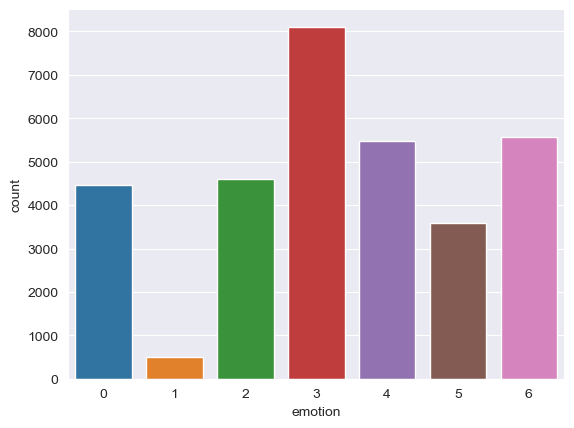

In [10]:
sns.countplot(x = df.emotion)
plt.show()

In [11]:
def augment_pixels(px, IMG_SIZE = 48):
    image = np.array(px.split(' ')).reshape(IMG_SIZE, IMG_SIZE).astype('float32')
    image = tf.image.random_flip_left_right(image.reshape(IMG_SIZE,IMG_SIZE,1))
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 12, IMG_SIZE + 12)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 1])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0, 255)
    augmented = image.numpy().reshape(IMG_SIZE,IMG_SIZE)
    str_augmented = ' '.join(augmented.reshape(IMG_SIZE*IMG_SIZE).astype('int').astype(str))
    return str_augmented

valcounts = df.emotion.value_counts()
valcounts_diff = valcounts[valcounts.idxmax()] - valcounts
for emotion_idx, aug_count in valcounts_diff.iteritems():
    sampled = df.query("emotion==@emotion_idx").sample(aug_count, replace=True)
    sampled['pixels'] = sampled.pixels.apply(augment_pixels)
    df = pd.concat([df, sampled])
    print(emotion_idx, aug_count)

C:\Users\Ichrak Hamdi\AppData\Local\Temp\ipykernel_2004\1638623756.py:14: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for emotion_idx, aug_count in valcounts_diff.iteritems():


3 0
6 2538
4 2627
2 3517
0 3648
5 4524
1 7618


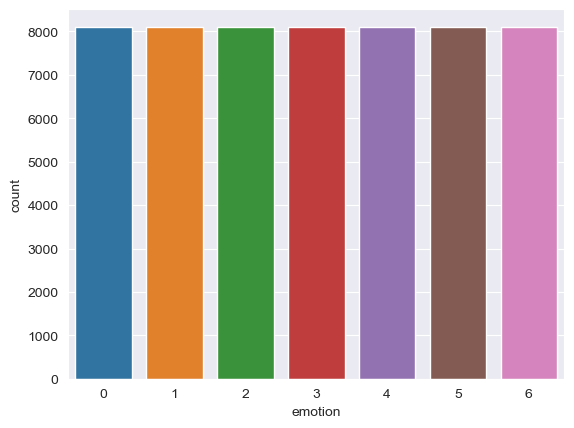

In [12]:
sns.countplot(x = df.emotion)
plt.show()

In [13]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    print()
    k = 0
    for i, row in enumerate(data.index):
        image = np.fromstring(data['pixels'][row], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
    return image_array

In [14]:
df.shape

(56770, 3)

In [15]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [16]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(56770, 7)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((45416, 48, 48, 1), (11354, 48, 48, 1), (45416, 7), (11354, 7))

In [18]:
model = Sequential()

input_shape = (48, 48, 1)

model.add(Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='relu', input_shape=input_shape))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(filters=128, kernel_size=5, padding='same', activation='relu', input_shape=input_shape))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(filters=512, kernel_size=5, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(7, activation='softmax'))

optimizer = RMSprop(learning_rate=0.001, rho=0.99)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, verbose=1,patience=2, min_lr=0.00000001)

callback = EarlyStopping(monitor='loss', patience=5)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        51264     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        51232     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       1

In [19]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=12,
                    batch_size=64)

Epoch 1/12
710/710 [==============================] - 358s 501ms/step - loss: 1.5812 - accuracy: 0.3871 - val_loss: 1.6917 - val_accuracy: 0.3631
Epoch 2/12
710/710 [==============================] - 559s 785ms/step - loss: 1.1838 - accuracy: 0.5549 - val_loss: 1.3248 - val_accuracy: 0.5082
Epoch 3/12
710/710 [==============================] - 396s 558ms/step - loss: 0.9832 - accuracy: 0.6323 - val_loss: 1.0877 - val_accuracy: 0.5769
Epoch 4/12
710/710 [==============================] - 370s 522ms/step - loss: 0.8029 - accuracy: 0.7035 - val_loss: 1.0919 - val_accuracy: 0.6026
Epoch 5/12
710/710 [==============================] - 334s 470ms/step - loss: 0.5976 - accuracy: 0.7873 - val_loss: 1.1162 - val_accuracy: 0.6180
Epoch 6/12
710/710 [==============================] - 660s 931ms/step - loss: 0.4019 - accuracy: 0.8616 - val_loss: 1.2006 - val_accuracy: 0.6387
Epoch 7/12
710/710 [==============================] - 437s 616ms/step - loss: 0.2623 - accuracy: 0.9122 - val_loss: 1.3560 -

In [20]:
print("loss: {0:.4f}, accuracy: {1:.4}, val_loss: {2:.4f}, val_accuracy: {3:.4}".format(history.history['loss'][-1], history.history['accuracy'][-1], history.history['val_loss'][-1], history.history['val_accuracy'][-1]))

loss: 0.1048, accuracy: 0.9676, val_loss: 1.8135, val_accuracy: 0.637


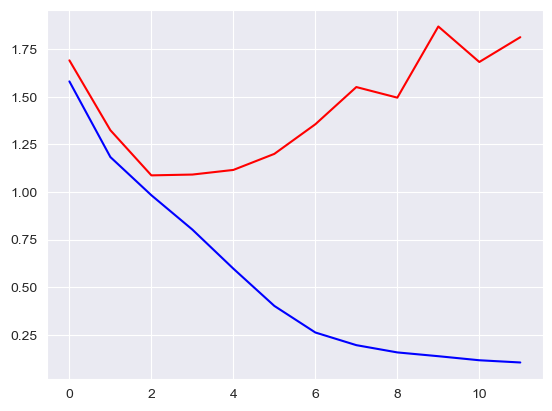

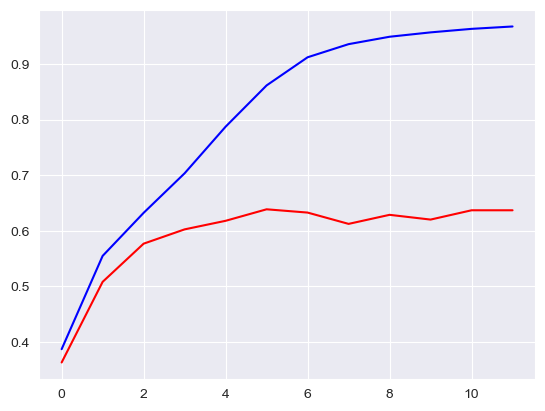

In [21]:
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.show()
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='r')
plt.show()

In [22]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
from keras.saving.model_config import model_from_json
model = model_from_json(open("model.json", "r").read())
#model.load_weights('best_model.h5')
face_haar_cascade = cv2.CascadeClassifier('venv\Data\haarcascade_frontalface_default.xml')

In [11]:
from tensorflow.keras.utils import img_to_array
cap=cv2.VideoCapture(0) # start webcam
while True:
    (valid,test_image)=cap.read() #reading image from video frame
    if not valid: #if not getting frames then exit
        break

    gray_image= cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) #converting the rgb image to grayscale


    faces_detected = face_haar_cascade.detectMultiScale(gray_image) #detecting faces from the image using haar_cascade
    for (x,y,w,h) in faces_detected: #cordinates of deteced faces
        cv2.rectangle(gray_image,(x,y), (x+w,y+h), (255,0,0)) #putting a rectange box around detected face
        roi_gray=gray_image[y:y+w,x:x+h]  # capturing only face from the image
        roi_gray=cv2.resize(roi_gray,(48,48)) # resizing it to 48,48 (that's what mdodel wants as an input)
        image_pixels = img_to_array(roi_gray) #converting image to array
        image_pixels = np.expand_dims(image_pixels, axis = 0) #expanding dims as model needs input in batches
        # image_pixels /= 255


        predictions = model.predict(image_pixels) #model prediction
        max_index = np.argmax(predictions[0]) #getting emotion index

        emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        emotion_prediction = emotion_detection[max_index]


        cv2.putText(test_image, emotion_prediction, (int(x), int(y)),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3) #putting text around face
    #   cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)


        resize_image = cv2.resize(test_image, (1000, 700)) #enhancing the image to display
        cv2.imshow('Emotion Dectector',resize_image)
        if cv2.waitKey(10) == ord('b'):
            break
cap.release()
cv2.destroyAllWindows

1/1 [==============================] - 0s 36ms/step


KeyboardInterrupt: 